# Shrew attack with a Telegraf overlay

In [1]:
import plot_utils
import rolling_funcs
from plot_utils import LogFile,LogFileType,Roller,Fig

WINDOW_SECS = 20.0

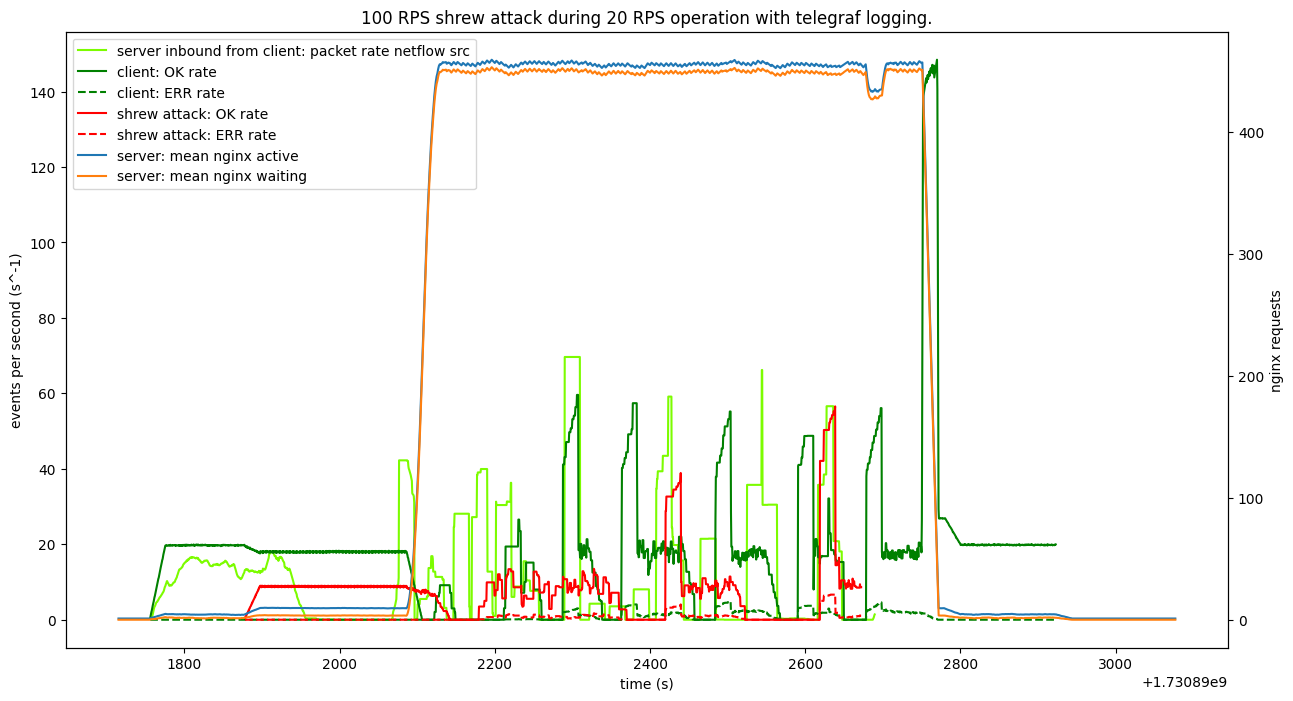

In [2]:
fig,ax = plot_utils.fig([
    Fig(title="100 RPS shrew attack during 20 RPS operation with telegraf logging.",x="time (s)",y="events per second (s^-1)")
])

telegraf_log = LogFile(log_type=LogFileType.TELEGRAF, path="./logs/hilbert/2024-11-06_11-15.json",
kwargs={'telegraf': {
    'nginx' : ['active', 'waiting']
}
})
netflow = LogFile(LogFileType.TELEGRAF,"./logs/hilbert/2024-11-06_11-15.json",
{'telegraf':{
    'netflow':[{'src':{'use_time':'flow_start_ms'}}]
},'color':'lawngreen'})

client_log = LogFile(log_type=LogFileType.GOT, path="./logs/kleene/2024-11-06_11-15-55.357761.txt",kwargs={'color':'g'})
shrew_log = LogFile(log_type=LogFileType.GOT, path="./logs/mac/2024-11-06_11-17-57.606971.txt",kwargs={'color':'r'})

mean_roller = Roller('mean', rolling_funcs.mean)

response_rollers = [
    Roller("OK rate", rolling_funcs.count_ok, rate=True),
    Roller("ERR rate", rolling_funcs.count_err, rate=True, kwargs={'linestyle':'--'}),
]
packet_rollers = [Roller('packet rate', rolling_funcs.count_kleene_packets,rate=True)]
# plot nginx on new scale
ax_zoom = ax.twinx()
ax_zoom.set_ylabel('nginx requests')

plot_utils.overlay_rolling(ax_zoom, {'server': telegraf_log}, [mean_roller],WINDOW_SECS,times_units='s')
plot_utils.overlay_rolling(ax, {'server inbound from client':netflow},packet_rollers,window_secs=WINDOW_SECS,const_stride_secs=0.5)
plot_utils.overlay_rolling(ax, {'client': client_log, 'shrew attack': shrew_log}, response_rollers, WINDOW_SECS, const_stride_secs=0.5, times_units='s')

plot_utils.show_combined_legends([ax,ax_zoom])
fig.savefig('./plots/shrew.png')